In [1]:
import torch
from torch import nn
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import seaborn as sns
import networkx as nx

In [2]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
import nltk

# Ensure necessary NLTK resources are available
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("averaged_perceptron_tagger")
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     /u/home/z/zhengton/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /u/home/z/zhengton/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /u/home/z/zhengton/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /u/home/z/zhengton/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /u/home/z/zhengton/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [5]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize VADER Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

# Define words to analyze
words = ["amazing", "terrible", "happy", "sad", "awesome", "horrible", "neutral"]

# Label words based on sentiment score
labels = {}
for word in words:
    sentiment_score = sia.polarity_scores(word)['compound']
    if sentiment_score > 0.5:
        labels[word] = "Strong Positive"
    elif sentiment_score < -0.5:
        labels[word] = "Strong Negative"
    else:
        labels[word] = "Neutral or Weak Sentiment"

# Output labeled words
print(labels)

{'amazing': 'Strong Positive', 'terrible': 'Neutral or Weak Sentiment', 'happy': 'Strong Positive', 'sad': 'Neutral or Weak Sentiment', 'awesome': 'Strong Positive', 'horrible': 'Strong Negative', 'neutral': 'Neutral or Weak Sentiment'}


In [6]:
class IMDBDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_length=512):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, idx):
        review = str(self.reviews[idx])
        target = self.targets[idx]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(target, dtype=torch.long),
            'review': review
        }

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2
).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
model.load_state_dict(torch.load('../ckpts/best_bert_imdb_model.pt'))

<All keys matched successfully>

In [10]:
df = pd.read_csv('../dataset/IMDB Dataset.csv')
reviews = df['review'].values
labels = (df['sentiment'] == 'positive').astype(int).values

In [11]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    reviews, labels, test_size=0.3, random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)

In [12]:
# Create datasets
train_dataset = IMDBDataset(train_texts, train_labels, tokenizer)
val_dataset = IMDBDataset(val_texts, val_labels, tokenizer)
test_dataset = IMDBDataset(test_texts, test_labels, tokenizer)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=1)

In [13]:
# all_attentions = []
# for test_data in tqdm(test_loader, total=len(test_loader)):
#     input_ids = test_data['input_ids'].to(device)
#     attention_mask = test_data['attention_mask'].to(device)
#     label = test_data['labels']
#     review = test_data['review']
#     with torch.no_grad():
#         output = model(input_ids, attention_mask=attention_mask, output_attentions=True)
#     _attentions = [att.detach().cpu().numpy() for att in output.attentions]
#     attentions_mat = np.asarray(_attentions)[:,0]
#     predicted = output['logits']
#     all_attentions.append({
#         "input_ids": input_ids,
#         "sentence": review,
#         "label": label,
#         "attention_mat": attentions_mat,
#         "prediction": predicted
#     })
#     del output
#     torch.cuda.empty_cache()

In [14]:
data_iter = iter(test_loader)
# next(data_iter)
test_data = next(data_iter)
input_ids = test_data['input_ids'].to(device)
attention_mask  = test_data['attention_mask'].to(device)
label = test_data['labels']
review = test_data['review']
output = model(input_ids, attention_mask=attention_mask, output_attentions=True)
print(label)

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


tensor([0])


In [15]:
_attentions = [att.detach().cpu().numpy() for att in output.attentions]
attentions_mat = np.asarray(_attentions)[:,0]
print(attentions_mat.shape)

(12, 12, 512, 512)


In [16]:
predicted = output['logits']
predicted

tensor([[0.3195, 0.1632]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [17]:
# Tokenize and part-of-speech tag the input text to filter syntax words
text = review[0]
tokens = word_tokenize(text)
pos_tags = pos_tag(tokens)
stop_words = set(stopwords.words("english"))
content_tokens = [word for word, pos in pos_tags if pos.startswith("NN") or pos.startswith("VB") or pos.startswith("JJ") and word.lower() not in stop_words]

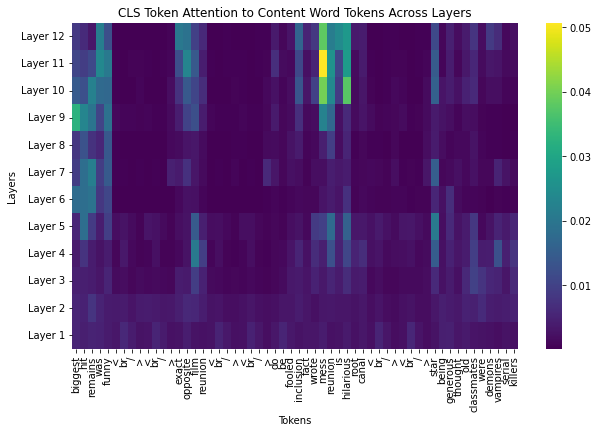

In [18]:
# Define a mask to exclude special tokens, punctuation, and syntax words
input_ids = input_ids.to("cpu")
cls_token_id = tokenizer.cls_token_id
sep_token_id = tokenizer.sep_token_id
pad_token_id = tokenizer.pad_token_id
punctuation_ids = [tokenizer.convert_tokens_to_ids(p) for p in [".", ",", "!", "?", ":", ";", "-", "..."]]

non_special_token_mask = (input_ids != cls_token_id) & (input_ids != sep_token_id) & (input_ids != pad_token_id)
non_punctuation_mask = ~torch.isin(input_ids, torch.tensor(punctuation_ids))
content_word_mask = torch.tensor([1 if tokenizer.decode(id).strip() in content_tokens else 0 for id in input_ids[0]], dtype=torch.bool)

# Combine all masks
valid_token_mask = non_special_token_mask & non_punctuation_mask & content_word_mask

# Filter CLS attention to only content words across layers
cls_attention_over_layers = []
for layer_attention in output.attentions:
    # CLS token's attention in this layer
    cls_attention = layer_attention[:, :, 0, :]
    # Apply the combined mask
    cls_attention_to_content_words = cls_attention[:, :, valid_token_mask[0]]
    cls_attention_over_layers.append(cls_attention_to_content_words.cpu().mean(dim=1).squeeze().detach().numpy())  # Average over heads

# Concatenate all layer attentions vertically
concatenated_attention = np.flip(np.vstack(cls_attention_over_layers), axis=0)

# Extract valid tokens for x-axis labels
tokens = tokenizer.convert_ids_to_tokens(input_ids[0][valid_token_mask[0]])

# Plot concatenated heatmap
plt.figure(figsize=(10, len(cls_attention_over_layers) * 0.5))
sns.heatmap(
    concatenated_attention,
    cmap="viridis",
    cbar=True,
    xticklabels=tokens,
    yticklabels=np.array([f"Layer {i + 1}" for i in range(len(cls_attention_over_layers))])[::-1],
)
plt.title("CLS Token Attention to Content Word Tokens Across Layers")
plt.xlabel("Tokens")
plt.ylabel("Layers")
plt.xticks(rotation=90)
plt.show()

In [22]:
labels = {}
for word in tokens:
    sentiment_score = sia.polarity_scores(word)['compound']
    labels[word] = sentiment_score

labels

{'biggest': 0.0,
 'hit': 0.0,
 'remains': 0.0,
 'was': 0.0,
 'funny': 0.4404,
 '<': 0.0,
 'br': 0.0,
 '/': 0.0,
 '>': 0.0,
 'exact': 0.0,
 'opposite': 0.0,
 'film': 0.0,
 'reunion': 0.0,
 'do': 0.0,
 'be': 0.0,
 'fooled': -0.3818,
 'inclusion': 0.0,
 'fact': 0.0,
 'wrote': 0.0,
 'mess': -0.3612,
 'is': 0.0,
 'hilarious': 0.4019,
 'root': 0.0,
 'canal': 0.0,
 'star': 0.0,
 'being': 0.0,
 'generous': 0.5106,
 'thought': 0.0,
 'old': 0.0,
 'classmates': 0.0,
 'were': 0.0,
 'demons': 0.0,
 'vampires': 0.0,
 'serial': 0.0,
 'killers': -0.6486}

In [30]:
indices = concatenated_attention.argmax(axis=1)
max_tokens = []
max_tokens_scores = []
max_att_scores = []
for k, idx in enumerate(indices):
    max_tokens.append(tokens[idx])
    max_tokens_scores.append(labels[tokens[idx]])
    max_att_scores.append(concatenated_attention[k, idx])
print(np.array(max_tokens), np.array(max_tokens_scores), np.array(max_att_scores))

['mess' 'mess' 'mess' 'biggest' 'funny' 'remains' 'remains' 'star' 'film'
 'classmates' 'remains' 'br'] [-0.3612 -0.3612 -0.3612  0.      0.4404  0.      0.      0.      0.
  0.      0.      0.    ] [0.03820699 0.05074184 0.04004065 0.03239263 0.01378967 0.02165103
 0.01940851 0.02050553 0.02050508 0.00996192 0.00771196 0.00572948]


In [133]:
def plot_attention_heatmap(att, s_position, t_positions, tokens):
    cls_att = np.flip(att[:,s_position, t_positions], axis=0)
    xticklb = input_tokens= [tokens[k] for k in range(len(tokens)) if k in t_positions]
    yticklb = [str(i) if i%2 ==0 else '' for i in np.arange(att.shape[0],0, -1)]
    ax = sns.heatmap(cls_att, xticklabels=xticklb, yticklabels=yticklb, cmap="YlOrRd")
    return ax


In [135]:
tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())
tokens = np.array(tokens)
valid_indices = np.where(tokens != '[PAD]')[0]
attentions_mat = attentions_mat[:, :, valid_indices, :]
attentions_mat = attentions_mat[:, :, :, valid_indices]
tokens = tokens[valid_indices]
attentions_mat.shape

(12, 12, 186, 186)

<Axes: >

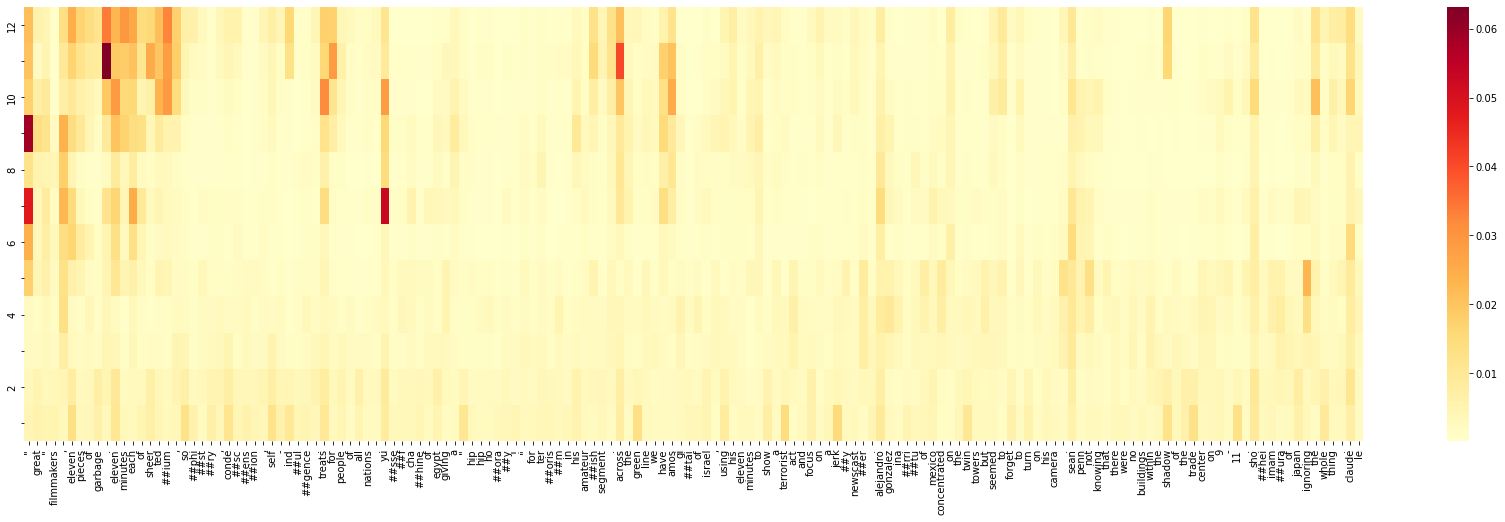

In [136]:
plt.figure(figsize=(30, 8))
plot_attention_heatmap(attentions_mat.sum(axis=1)/attentions_mat.shape[1], 0, 
                       t_positions=np.arange(num_tokens)[1:-1], tokens=tokens[1:-1])

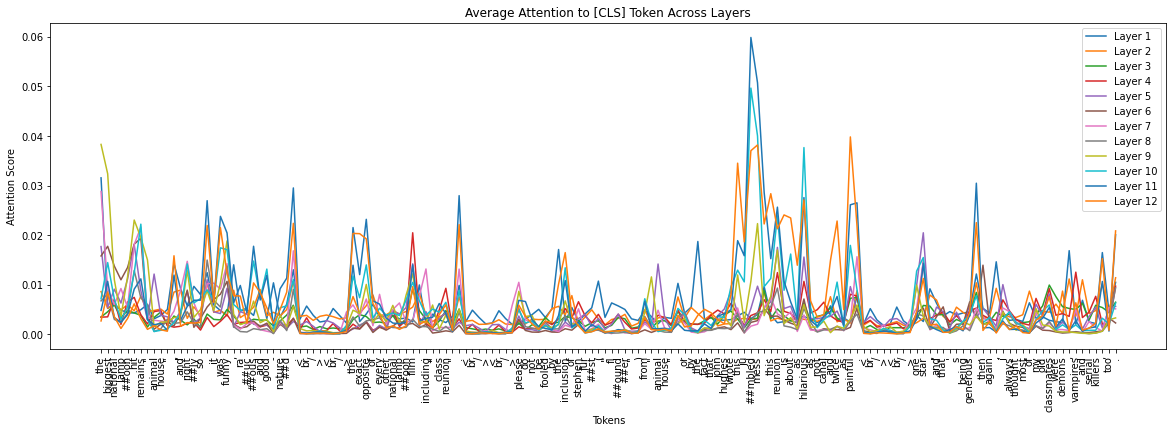

In [123]:
avg_cls_attention_over_layers = attentions_mat[:, :, 0, 1:-1].mean(axis=1)

plt.figure(figsize=(20, 6))
for layer_num, avg_attention in enumerate(avg_cls_attention_over_layers):
    plt.plot(avg_attention, label=f'Layer {layer_num + 1}')
plt.title("Average Attention to [CLS] Token Across Layers")
plt.xlabel("Tokens")
plt.ylabel("Attention Score")
plt.xticks(np.arange(len(tokens)-2), tokens[1:-1], rotation=90)
plt.legend()
plt.show()